#Transfer Learning from DenseNet-169

In this notebook, we use transfer learning from the DenseNet-169 convolutional neural network to train a model for disease detection from chest X-rays. The data used is from Stanford University's CheXpert dataset, and the final model is developed with the aim of detecting the presence of 5 diseases, namely Atelectasis, Edema, Cardiomegaly, Consolidation, Pleural Effusion.

We first extract the file 'chexpert.zip' using the following Python code. (Note that we could have simply used the `!unzip` command, but it feels good to be able to see how much progress has been made when extracting large files. :P) 

In [ ]:
from zipfile import ZipFile

zf = ZipFile('chexpert.zip')
uncompressed_size = sum((file.file_size for file in zf.infolist()))
print('Uncompressed size:', uncompressed_size/1e9, 'GB.')

extracted_size = 0
extracted_percent = 0

for file in zf.infolist():
    extracted_size += file.file_size
    last_percent = extracted_percent
    extracted_percent = extracted_size * 100/uncompressed_size
    for i in range(10, 110, 10):
        if last_percent < i and extracted_percent >= i:
            print(str(i)+'% complete')
    try:
        zf.extract(file)
    except:
        continue

Uncompressed size: 11.471429175 GB.
10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete
100% complete


In [ ]:
!rm chexpert.zip

In [ ]:
import cv2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import optimizers
from keras import metrics
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet169
from keras.applications.densenet import preprocess_input

Using TensorFlow backend.


In [ ]:
train_df = pd.read_csv('CheXpert-v1.0-small/train.csv')
val_df = pd.read_csv('CheXpert-v1.0-small/valid.csv')

Let's see what the dataset looks like.

In [ ]:
train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [ ]:
val_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


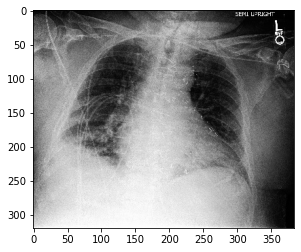

In [ ]:
n = np.random.randint(len(train_df))
img_path = train_df['Path'][n]
img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

We need a way to deal with `NaN` values and uncertain values in our data. In accordance with the observations made in the [state-of-the-art paper](https://arxiv.org/pdf/1911.06475.pdf) on this topic, we decide to replace all `NaN` values with 0 and all uncertain (-1) values with 1 (for Atelectasis and Edema), or 0 (for Cardiomegaly, Consolidation, and Pleural Effusion).

In [ ]:
columns_u_ones = ['Atelectasis', 'Edema']
columns_u_zeros = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']
classes = columns_u_ones + columns_u_zeros

def fill_up(df):
    df = df[['Path'] + classes]
    df.fillna(0, inplace=True)
    df[columns_u_ones] = df[columns_u_ones].replace(-1, 1)
    df[columns_u_zeros] = df[columns_u_zeros].replace(-1, 0)
    return df

train_df, val_df = fill_up(train_df), fill_up(val_df)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


We next prepare the image generators, with appropriate data augmentation:

In [ ]:
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    validation_split=0.1)

In [ ]:
paths_for_normalizing = train_df['Path'].sample(frac=5e-3).to_numpy()
images_for_normalizing = np.array([np.array(cv2.imread(img_path, 1), dtype=float) for img_path in paths_for_normalizing])
normalization_sample = np.array([x for x in images_for_normalizing if x.shape == (320, 390, 3)])

In [ ]:
train_datagen.fit(normalization_sample)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Path',
    y_col=classes,
    seed=42,
    shuffle=True,
    target_size=(224, 224),
    batch_size=24,
    class_mode='raw',
    subset='training')

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Path',
    y_col=classes,
    seed=42,
    shuffle=True,
    target_size=(224, 224),
    batch_size=24,
    class_mode='raw',
    subset='validation')

Found 201073 validated image filenames.
Found 22341 validated image filenames.


In [ ]:
conv_base = DenseNet169(include_top=False, weights='imagenet', input_shape=(224,224,3))

51879936/51877672 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

We now build the model, using the convolutional base from DenseNet-169, setting all layers to be trainable since we have a huge dataset.

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='sigmoid'))

conv_base.trainable = True

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1664)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1704960   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 14,357,061
Trainable params: 14,196,613
Non-trainable params: 160,448
____________________________________

We use the Adam optimizer with a learning rate of 10<sup>-4</sup>, and for metrics, we use the area under ROC curve and the categorical accuracy.

In [ ]:
mc = callbacks.ModelCheckpoint(filepath='DenseNet169.h5', verbose=1)
callbacks_list = [mc]

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=[metrics.AUC(), metrics.categorical_accuracy])

We run the following code repeatedly (observing the results at the end of each epoch) to train our model. In this case, the model was trained for 3 epochs.

In [ ]:
from google.colab import drive
drive.mount('gdrive')

In [ ]:
model.load_weights('gdrive/My Drive/DenseNet-169.h5')

In [ ]:
model.fit_generator(
    train_generator,
    epochs=1,
    validation_data=val_generator,
    callbacks=callbacks_list)

In [ ]:
from keras.models import model_from_json

json_file = open('gdrive/My Drive/DenseNet-169.json', 'r')
model_architecture = json_file.read()
json_file.close()
model = model_from_json(model_architecture)
model.load_weights('gdrive/My Drive/DenseNet-169.h5')

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Path',
    y_col=classes,
    shuffle=False,
    target_size=(224, 224),
    batch_size=1,
    class_mode='raw')

Found 234 validated image filenames.


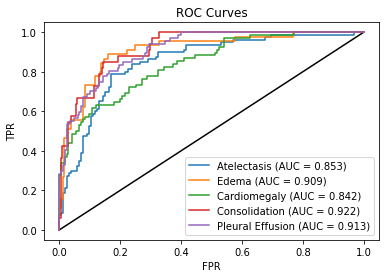

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_actual = val_df[classes].to_numpy()
y_preds = model.predict_generator(test_generator, steps=test_generator.n)

plt.figure()
plt.plot([0, 1], [0, 1], 'k-')

for i in range(len(classes)):
   fpr, tpr, thresholds = roc_curve(y_actual[:, i], y_preds[:, i])
   individual_auc = auc(fpr, tpr)
   plt.plot(fpr, tpr, label=(classes[i] + f' (AUC = {round(individual_auc, 3)})'))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_json = model.to_json()
with open('DenseNet-169.json', 'w') as json_file:
    json_file.write(model_json)

In [ ]:
import h5py

model.save_weights('gdrive/My Drive/DenseNet-169.h5')

In [ ]:
!cp 'DenseNet-169.json' 'gdrive/My Drive/'